## Import datasets

In [1]:
import pandas as pd

# Save data splits
df_train = pd.read_csv('../proc/extra/df_train.csv')
df_test = pd.read_csv('../proc/extra/df_test.csv')

target = 'OA'

In [2]:
df_meta = pd.read_csv('../dict/Demographics_ALL.csv', sep=';')
df_meta = df_meta.drop_duplicates(subset=['Identifier'])
df_train = df_train.merge(df_meta, how='left', left_on='Identifier', right_on='Identifier')
df_test = df_test.merge(df_meta, how='left', left_on='Identifier', right_on='Identifier')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import numpy as np
import Functions as func
import pickle

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01) # 0.05
X_feat = tfidf_vectorizer.fit_transform(df_train['proc_RTFscripted'].values)
importance = np.argsort(np.asarray(X_feat.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

with open('../model/tfidf/tfidf_vectorizer.pk', 'wb') as fin:
    pickle.dump(tfidf_vectorizer, fin)

# Show top 10 features
print('Top 10 most frequent features:', tfidf_feature_names[importance[:10]])

# get feature names
feature_names = np.array(tfidf_vectorizer.get_feature_names())
sorted_by_idf = np.argsort(tfidf_vectorizer.idf_)
print("Top 10 with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nTop 10 with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Top 10 most frequent features: ['laboratorium' 'deelcontact' 'de' 'labuitslagen' 'geen' 'huisartsen' 'in'
 'st' '1t' 'tabl']
Top 10 with lowest idf:
['deelcontact' 'huisarts' 'vraagstelling' 'procedurevoorstel' 'de' 'in'
 'probleemlijst' 'geen' 'contra' 'klachten']

Top 10 with highest idf:
['proximale' 'recidiverend' 'lotion' 'aios' 'lijst' 'code'
 'codeinefosfaat' 'ld' 'augustus' 'orde']


### Step 2:  Perform batch correction on train data

In [4]:
from combat.pycombat import pycombat
from scipy.sparse import csr_matrix

df_train_tfidf = pd.DataFrame(X_feat.toarray(), columns=tfidf_feature_names).T
df_train_tfidf

l_batch_train = list(df_train['Locatie'])
data_corrected = df_train_tfidf.copy()
X_feat = np.array(data_corrected.T)

# Convert to CSR sparse matrix
X_feat = csr_matrix(X_feat)

### Step 3: Show prevalence of OA patients

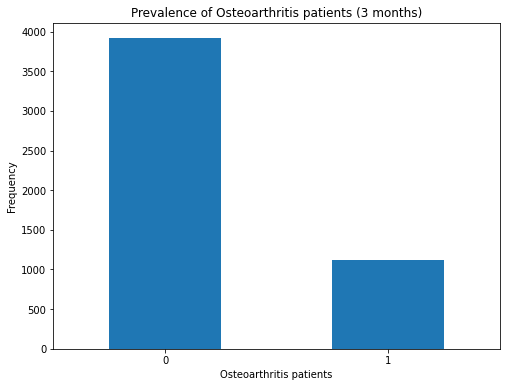

In [5]:
import matplotlib.pyplot as plt

# Count the frequency of each category
category_counts = df_train['OA'].value_counts()
category_counts = category_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
category_counts.plot( kind='bar')
plt.title('Prevalence of Osteoarthritis patients (3 months)')
plt.xlabel('Osteoarthritis patients')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Remove this line if you want rotated x-axis labels
plt.show()

## Step 4: Build Classifier for OA patients 

### Step 4.1: Load Classifier for OA patients 

In [31]:
import pickle
TARGET = 'OA'

with open('/exports/reum/tdmaarseveen/gitlab/referral_ml/model/tfidf/tfidf_vectorizer_%s_ngram_1000iter_new.pk' % TARGET, 'rb') as fin:
    tfidf_vectorizer = pickle.load(fin)
    
with open('/exports/reum/tdmaarseveen/gitlab/referral_ml/model/xgb/xgb_%s_ngram_1000iter_new.pk' % TARGET, 'rb') as fin:
    bst = pickle.load(fin)


### Step 4.2 Check performance on training data

In [32]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

y_train = df_train[TARGET].copy() #, label=y
y_pred_train = []

# Apply 5 fold CV
kf = KFold(n_splits=5) 

# Final params from hyperparam training

#params = {'objective': "binary:logistic",'num_class':1, "eval_metric": "logloss", 'booster': 'gbtree', 'lambda': 2.4891415522285602e-08, 'alpha': 0.0009258531009631025, 'learning_rate': 0.0591983520824831, 'subsample': 0.5301123188643551, 'colsample_bytree': 0.9787115860841581, 'max_depth': 4, 'eta': 4.264632192014755e-05, 'gamma': 3.1754913392388276e-05, 'grow_policy': 'depthwise'}

#params = {'objective': "binary:logistic",'num_class':1, "eval_metric": "logloss", 'booster': 'gbtree', 'lambda': 0.015497065643025942, 'alpha': 0.001905425112407049, 'learning_rate': 0.19481758960730522, 'subsample': 0.8720625867442774, 'colsample_bytree': 0.793930212159126, 'max_depth': 2, 'eta': 1.146693627869519e-06, 'gamma': 0.0016505875894815424, 'grow_policy': 'lossguide', 'objective': 'binary:logistic', 'num_class': 1, 'eval_metric': 'logloss'}
params = {'objective': "binary:logistic",'num_class':1, "eval_metric": "logloss", 'booster': 'gbtree', 'lambda': 9.210444590151525e-06, 'alpha': 0.00047298776514252954, 'learning_rate': 0.28308950311019343, 'subsample': 0.9906051780448373, 'colsample_bytree': 0.5027371380318854, 'max_depth': 4, 'eta': 4.92595300239557e-06, 'gamma': 2.208293206123679e-08, 'grow_policy': 'lossguide', 'objective': 'binary:logistic', 'num_class': 1, 'eval_metric': 'logloss'}
for train_index, test_index in kf.split(df_train['proc_RTFscripted']):
        
        train_x, test_x = df_train['proc_RTFscripted'].loc[train_index].values, df_train['proc_RTFscripted'].loc[test_index].values
        train_y, test_y = np.take(y_train, np.array(train_index)), np.take(y_train, np.array(test_index))

        tfidf = TfidfVectorizer(max_df=0.9, min_df=0.01, ngram_range=(1,3))
        X_feat_train = tfidf.fit_transform(train_x)
        X_feat_test = tfidf.transform(test_x)

        dtrain = xgb.DMatrix(X_feat_train, label=train_y)
        dtest = xgb.DMatrix(X_feat_test, label=test_y)
        
        bst_train = xgb.train(params, dtrain, evals=[(dtest, "validation")], verbose_eval=1) 
        preds = bst_train.predict(dtest)
        
        # Create a confusion matrix over all data!
        y_pred_train.extend(preds)


[0]	validation-logloss:0.59653
[1]	validation-logloss:0.55266
[2]	validation-logloss:0.52523
[3]	validation-logloss:0.50662
[4]	validation-logloss:0.49315
[5]	validation-logloss:0.48776
[6]	validation-logloss:0.48396
[7]	validation-logloss:0.48246
[8]	validation-logloss:0.47630
[9]	validation-logloss:0.47486
[0]	validation-logloss:0.59386
[1]	validation-logloss:0.53517
[2]	validation-logloss:0.50539
[3]	validation-logloss:0.48375
[4]	validation-logloss:0.47169
[5]	validation-logloss:0.46070
[6]	validation-logloss:0.45427
[7]	validation-logloss:0.45308
[8]	validation-logloss:0.45250
[9]	validation-logloss:0.45089
[0]	validation-logloss:0.60662
[1]	validation-logloss:0.54998
[2]	validation-logloss:0.51897
[3]	validation-logloss:0.50011
[4]	validation-logloss:0.49077
[5]	validation-logloss:0.48934
[6]	validation-logloss:0.48678
[7]	validation-logloss:0.48546
[8]	validation-logloss:0.48604
[9]	validation-logloss:0.48113
[0]	validation-logloss:0.59116
[1]	validation-logloss:0.53743
[2]	vali

### Step 4.3 Check performance on validation data

In [33]:
X_feat_test = tfidf_vectorizer.transform(df_test['proc_RTFscripted'])
y = df_test['OA']
dtest = xgb.DMatrix(X_feat_test, label=y)

y_pred = bst.predict(dtest)

### Step 4.4 Check confusion matrix

Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.80)')

<Figure size 576x432 with 0 Axes>

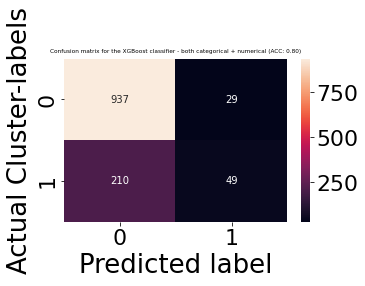

In [34]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np

fig = plt.figure()

threshold = 0.5
cm = confusion_matrix(y, np.array(y_pred)> threshold).astype('float')
accuracy = accuracy_score(y, np.array(y_pred)> threshold).astype('float')

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.79)')

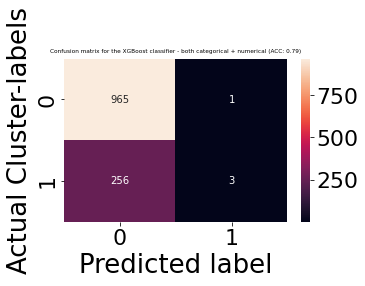

In [35]:
threshold = 0.66
cm = confusion_matrix(y, np.array(y_pred)> threshold).astype('float')
accuracy = accuracy_score(y, np.array(y_pred)> threshold).astype('float')

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

#### Calculate CI for AUC-ROC in validation set

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'Pred' : y_pred, 'OA' : y})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['OA'], df_pred['Pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['OA']), len(df_pred['OA']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['OA'], resampled_data['Pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.67081789 0.74054617]


#### Calculate PR-AUC CI for validation set

In [37]:
from sklearn.metrics import roc_auc_score,  precision_recall_curve, auc
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'Pred' : y_pred, 'OA' : y})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['OA'], df_pred['Pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['OA']), len(df_pred['OA']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    prec_re, recall_re, _ = precision_recall_curve(resampled_data['OA'], resampled_data['Pred'])
    resampled_auc = auc(recall_re, prec_re)
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')


95% Confidence Interval: [0.39623146 0.51887614]


#### Render swarm plot to show distribution (to inform choice of cut-off)

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 18.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


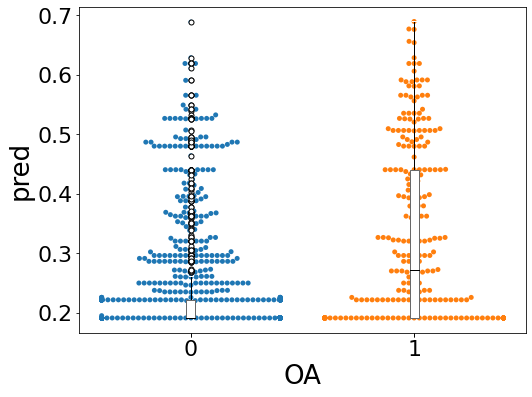

In [38]:
import seaborn as sns
params = {'legend.fontsize': 10,
          'figure.figsize': (8,6),
          'axes.grid': False,
         'axes.labelsize': 26,
         'axes.titlesize':'xx-small',
         'xtick.labelsize':22,
          'axes.labelcolor' : 'k',
          'ytick.color' : 'k',
          'xtick.color': 'k',
        'font.weight':'regular',
         'ytick.labelsize':22}
plt.rcParams.update(params)

df_pred = pd.DataFrame(y_pred, columns=['pred'] )
df_pred['OA'] = y.astype(int)

# Create a violin plot
fig, ax = plt.subplots()

# Create a violin plot
sns.swarmplot(x="OA", y="pred", ax=ax, data=df_pred, zorder=0)

for category in [0, 1]:
    subset = df_pred[df_pred['OA'] == category]['pred']
    ax.boxplot(subset, positions=[category], widths=0.04, patch_artist=True, boxprops=dict(color='dimgray', facecolor='white'), 
               medianprops=dict(color='black'), whiskerprops=dict(color='black'), capprops=dict(color='white'), 
               flierprops=dict(markerfacecolor='white', marker='o', markersize=5, linestyle='none', markeredgecolor='black'))

# Show the plot
plt.show()

#### render calibration curve

Brier score: 0.1475296885664995


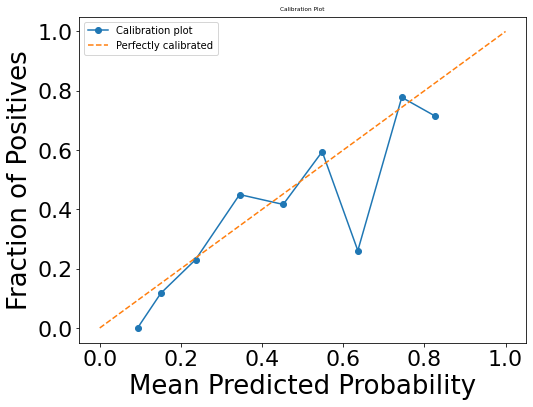

In [28]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import pandas as pd

df_pred = pd.DataFrame(y_pred, columns=['pred'] )
df_pred['OA'] = list(y)

print('Brier score:', brier_score_loss(df_pred['OA'], df_pred['pred']))

# Create a calibration plot
prob_true, prob_pred = calibration_curve(df_pred['OA'], df_pred['pred'], n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

## Step 5: Assess performance

In [15]:
#import collections.OrderedDict
from collections import Counter
from typing_extensions import OrderedDict

def sortedPredictionList(b_pred, y_test):
    """
    This function sorts the list of true labels by the
    list of predictions. The sorted list of true labels
    can be used to create a ROC-curve for a non-probability
    classifier (a.k.a. a binary classifier like decision tree).

    Input:
        b_pred = list of hard-predictions (0 or 1) 
            or probabilities (0-1)
        y_test = list of actual labels, binarized to 
            1 or 0. 

    Example for generating 'l_sorted_true':
        Before sort:
           pred: 0 1 1 0 1 0 1 0 1 1 1 0 1 0
           true: 0 1 0 0 1 0 0 1 1 0 1 0 1 1
        After sort:
           pred: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 
        -> true: 1 1 0 1 0 0 1 1 0 0 1 1 0 0

    Output:
        l_sorted_true = list of true label sorted on the 
            predictions label:
    """
    pred, y_test = list(y_wm.astype(int)), list(y_test)
    df_pred = pd.DataFrame(pred, y_test).reset_index()
    df_pred.columns = ['pred', 'true']
    df_pred = df_pred.sort_values(by='pred', ascending=False) #.to_csv('')
    return list(df_pred['pred']),  list(df_pred['true'])

def infer_binary(pred, y_test):
    #print(pred, y_test)
    l_pred, l_true = sortedPredictionList(pred, y_test)
    dummi = l_pred
    dummi = [2 if x==0 else x for x in dummi]
    dummi = [x -1 for x in dummi]
    l_pred.insert(0,0)
    l_true.insert(0,0)
    dummi.insert(0,0)
    # Compute basic statistics:
    TP = pd.Series(l_true).cumsum()
    FP = pd.Series(dummi).cumsum()
    P = sum(l_true)
    N = sum(dummi)
    TPR = TP.divide(P) # sensitivity / hit rate / recall
    FPR = FP.divide(N)  # fall-out
    PRC = TP.divide(TP + FP) # precision
    F1 = 2 * (PRC * TPR) / (PRC + TPR)
    d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred, 'f1': F1}
    #d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred}
    return d_conf

def scoresCM(CM):
    """
    Derive performance characteristics from the confusion matrix
    """
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {'tpr': TPR, 'tnr': TNR,'ppv': PPV, 'npv': NPV, 'fpr': FPR, 'fnr' : FNR, 'fdr' : FDR, 'acc' : ACC} 

#d_conf = infer_binary(list(y_wm.astype(int)), list(y_gold))

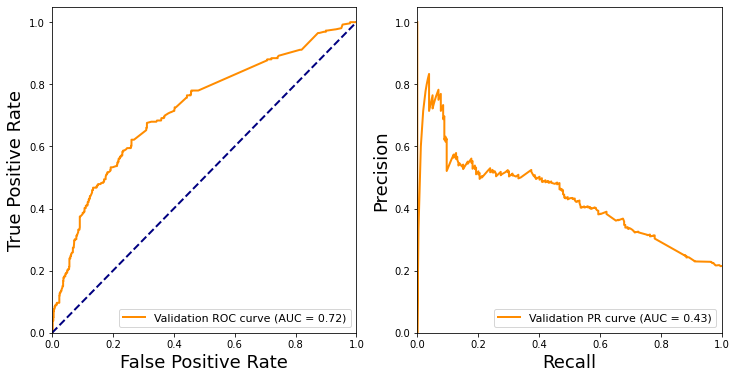

In [16]:
### import numpy as np

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)


fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = 'XGBoost (Machine learning)'

# Validation performance
fpr_v, tpr_v, _ = roc_curve(y, y_pred) # np.array([binarize(val) for val in y_actual])
prec_v, recall_v, _ = precision_recall_curve(y, y_pred)

pr_auc_v = auc(recall_v, prec_v)
roc_auc_v = auc(fpr_v, tpr_v)


lw = 2


# Also plot validation
ax1[0].plot(fpr_v, tpr_v, color='darkorange',
        lw=lw, label='%s ROC curve (AUC = %0.2f)' % ('Validation', roc_auc_v))
ax1[1].plot(recall_v, prec_v,  color='darkorange',
        lw=lw, label='%s PR curve (AUC = %0.2f)' % ('Validation', pr_auc_v))


## ROC
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)

ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)

ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

# Plot legend
ax1[1].legend(loc="lower right", fontsize=11)
ax1[0].legend(loc="lower right", fontsize=11)



plt.show()

### Assess other performance metrics (also for defining cut-off)

In [29]:
for i in np.arange(0.30, 0.92, 0.01):
    cm = confusion_matrix(y.astype(int), np.array(y_pred) > i).astype('float')
    d_scores = scoresCM(cm)
    print('Thresh=%.2f \t' % i + '; '.join(['%s = %.2f' % (k, d_scores[k]) for k in d_scores.keys()]))

Thresh=0.30 	tpr = 0.47; tnr = 0.86; ppv = 0.48; npv = 0.86; fpr = 0.14; fnr = 0.53; fdr = 0.52; acc = 0.78
Thresh=0.31 	tpr = 0.44; tnr = 0.87; ppv = 0.48; npv = 0.85; fpr = 0.13; fnr = 0.56; fdr = 0.52; acc = 0.78
Thresh=0.32 	tpr = 0.42; tnr = 0.88; ppv = 0.49; npv = 0.85; fpr = 0.12; fnr = 0.58; fdr = 0.51; acc = 0.78
Thresh=0.33 	tpr = 0.41; tnr = 0.89; ppv = 0.50; npv = 0.85; fpr = 0.11; fnr = 0.59; fdr = 0.50; acc = 0.79
Thresh=0.34 	tpr = 0.39; tnr = 0.89; ppv = 0.50; npv = 0.85; fpr = 0.11; fnr = 0.61; fdr = 0.50; acc = 0.79
Thresh=0.35 	tpr = 0.39; tnr = 0.90; ppv = 0.51; npv = 0.85; fpr = 0.10; fnr = 0.61; fdr = 0.49; acc = 0.79
Thresh=0.36 	tpr = 0.32; tnr = 0.92; ppv = 0.51; npv = 0.83; fpr = 0.08; fnr = 0.68; fdr = 0.49; acc = 0.79
Thresh=0.37 	tpr = 0.30; tnr = 0.92; ppv = 0.50; npv = 0.83; fpr = 0.08; fnr = 0.70; fdr = 0.50; acc = 0.79
Thresh=0.38 	tpr = 0.30; tnr = 0.93; ppv = 0.52; npv = 0.83; fpr = 0.07; fnr = 0.70; fdr = 0.48; acc = 0.79
Thresh=0.39 	tpr = 0.27; tnr

/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
/exports/reum/tdmaarseveen/custom_enviro

#### [unused] Check for sub populations
- do we see that certain demographics receive higher model scores?

Total: 1225; OA pat: 259 (21.14%)


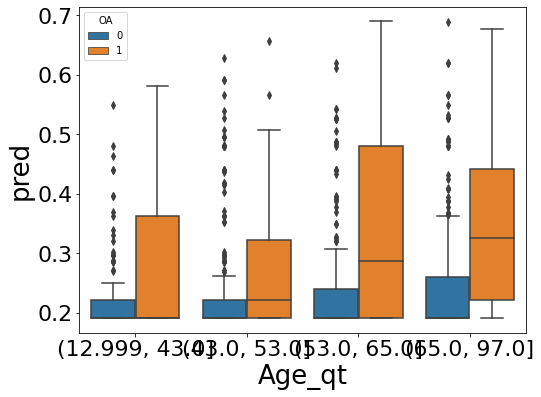

In [20]:
import seaborn as sns
print('Total: %s; OA pat: %s (%.2f' % (len(df_pred), df_pred['OA'].sum(), (df_pred['OA'].sum()/len(df_pred))*100) + '%)')
#df_pred = pd.DataFrame(y_pred, columns=['pred'] )
#df_pred['FMS'] = y_lbl.astype(int)
df_pred['Sex'] = df_test['Sex']
# Stratify the age groups using pd.qcut for quantile-based bins
df_pred['Age_qt'] = pd.qcut(df_test['Age'], q=4)

# Display the DataFrame with quantile-based age groups

# Create a violin plot
sns.boxplot(x="Age_qt", y="pred", data=df_pred, hue='OA')

# Show the plot
plt.show()

## Step 6: apply on test set
### 6.1 prepare test set

In [17]:
import pandas as pd 

df_replication = pd.read_csv('../proc/extra/df_replication.csv')

#df_replication
#df_sub = df_test.copy()#df_test[df_test['Age']<=40].copy()#[df_test['Sex'] == 1].copy()

Thresh=0.50 	tpr = 0.18; tnr = 0.97; ppv = 0.66; npv = 0.77; fpr = 0.03; fnr = 0.82; fdr = 0.34; acc = 0.76


Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.76)')

<Figure size 576x432 with 0 Axes>

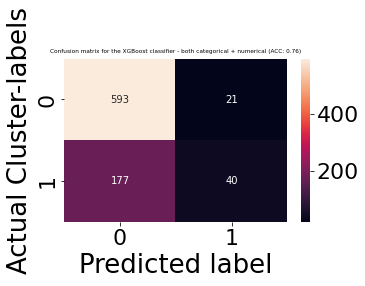

In [18]:
from combat.pycombat import pycombat
from scipy.sparse import csr_matrix

X_gold_test = tfidf_vectorizer.transform(df_replication['fixedLine'].values)
#X_gold_test = pd.DataFrame.sparse.from_spmatrix(X_gold_test)

y_gold = df_replication[target]
dgold = xgb.DMatrix(X_gold_test, label=y_gold)

y_pred_gold = bst.predict(dgold)
#y_pred

fig = plt.figure()

threshold = 0.50
cm = confusion_matrix(y_gold, np.array(y_pred_gold)> threshold).astype('float')
accuracy = accuracy_score(y_gold, np.array(y_pred_gold)> threshold).astype('float')

d_scores = scoresCM(cm)
print('Thresh=%.2f \t' % threshold + '; '.join(['%s = %.2f' % (k, d_scores[k]) for k in d_scores.keys()]))

df_cm = pd.DataFrame(cm, index = list(range(len(y_gold.unique()))),
                  columns = list(range(len(y_gold.unique()))))
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

### Render PR & ROC curve  of both models

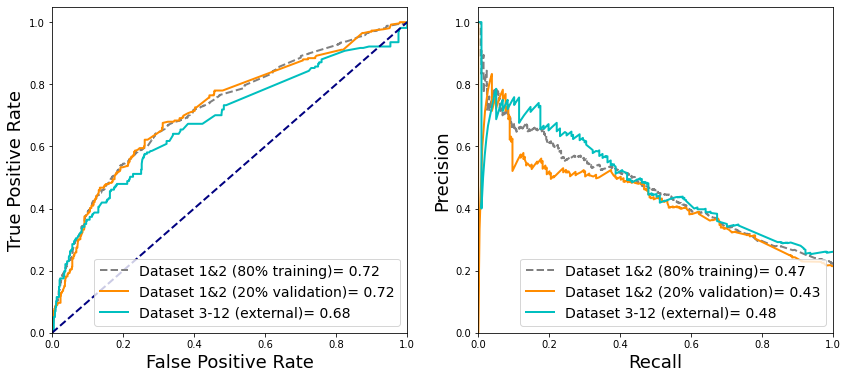

In [30]:
### import numpy as np

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)

fpr, tpr, _ = roc_curve(y_gold, y_pred_gold) # np.array([binarize(val) for val in y_actual])
prec, recall, _ = precision_recall_curve(y_gold, y_pred_gold)

pr_auc = auc(recall, prec)
roc_auc = auc(fpr, tpr)

fig1, ax1 = plt.subplots(1,2,figsize=(14,6))

clf_name = 'XGBoost (Machine learning)'

# Also show performance word matching
y_wm =  ~df_replication['WM'].isna()
# Use same model

# Validation performance
fpr_v, tpr_v, _ = roc_curve(y, y_pred) 
prec_v, recall_v, _ = precision_recall_curve(y, y_pred)

pr_auc_v = auc(recall_v, prec_v)
roc_auc_v = auc(fpr_v, tpr_v)

# Training performance
fpr_t, tpr_t, _ = roc_curve(y_train, y_pred_train) 
prec_t, recall_t, _ = precision_recall_curve(y_train, y_pred_train)

pr_auc_t = auc(recall_t, prec_t)
roc_auc_t = auc(fpr_t, tpr_t)


lw = 2

# Also plot training
ax1[0].plot(fpr_t, tpr_t, color='gray', linestyle='--',
        lw=lw, label='Dataset 1&2 (80%s training)= %0.2f' % ('%', roc_auc_t))
ax1[1].plot(recall_t, prec_t,  color='gray', linestyle='--',
        lw=lw, label='Dataset 1&2 (80%s training)= %0.2f' % ('%', pr_auc_t))

# Also plot validation
ax1[0].plot(fpr_v, tpr_v, color='darkorange',
        lw=lw, label='Dataset 1&2 (20%s validation)= %0.2f' % ('%', roc_auc_v))
ax1[1].plot(recall_v, prec_v,  color='darkorange',
        lw=lw, label='Dataset 1&2 (20%s validation)= %0.2f' % ('%', pr_auc_v))


## ROC
ax1[0].plot(fpr, tpr, color='c',
         lw=lw, label='Dataset 3-12 (external)= %0.2f' % (roc_auc))
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)

ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].plot(recall, prec, color='c',
         lw=lw, label='Dataset 3-12 (external)= %0.2f' % (pr_auc))
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)

ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

# Plot legend
ax1[1].legend(loc="lower right", fontsize=14)
ax1[0].legend(loc="lower right", fontsize=14)


plt.show()

### 6.2 Apply on test data

Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.75)')

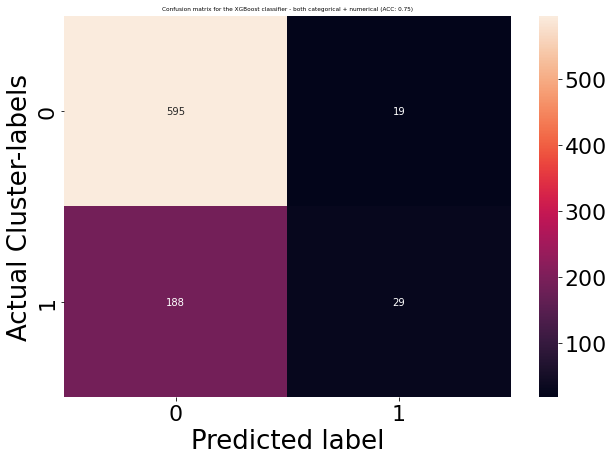

In [24]:
threshold = 0.50

cm = confusion_matrix(y_gold, np.array(y_pred_gold)> threshold).astype('float')
accuracy = accuracy_score(y_gold, np.array(y_pred_gold)> threshold).astype('float')


df_cm = pd.DataFrame(cm, index = list(range(len([0,1]))),
                  columns = list(range(len([0,1]))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

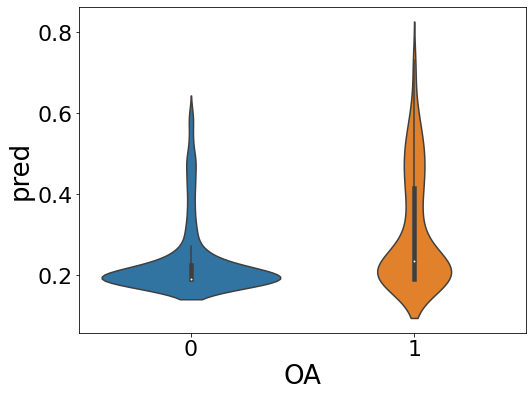

In [25]:
import seaborn as sns
df_pred = pd.DataFrame(y_pred_gold, columns=['pred'] )
df_pred['OA'] = y_gold.astype(int)

# Create a violin plot
sns.violinplot(x="OA", y="pred", data=df_pred)

# Show the plot
plt.show()

In [26]:
#import collections.OrderedDict
from collections import Counter
from typing_extensions import OrderedDict

def sortedPredictionList(b_pred, y_test):
    """
    This function sorts the list of true labels by the
    list of predictions. The sorted list of true labels
    can be used to create a ROC-curve for a non-probability
    classifier (a.k.a. a binary classifier like decision tree).

    Input:
        b_pred = list of hard-predictions (0 or 1) 
            or probabilities (0-1)
        y_test = list of actual labels, binarized to 
            1 or 0. 

    Example for generating 'l_sorted_true':
        Before sort:
           pred: 0 1 1 0 1 0 1 0 1 1 1 0 1 0
           true: 0 1 0 0 1 0 0 1 1 0 1 0 1 1
        After sort:
           pred: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 
        -> true: 1 1 0 1 0 0 1 1 0 0 1 1 0 0

    Output:
        l_sorted_true = list of true label sorted on the 
            predictions label:
    """
    pred, y_test = list(y_wm.astype(int)), list(y_gold)
    df_pred = pd.DataFrame(pred, y_test).reset_index()
    df_pred.columns = ['pred', 'true']
    df_pred = df_pred.sort_values(by='pred', ascending=False) #.to_csv('')
    return list(df_pred['pred']),  list(df_pred['true'])

def infer_binary(pred, y_test):
    #print(pred, y_test)
    l_pred, l_true = sortedPredictionList(pred, y_test)
    dummi = l_pred
    dummi = [2 if x==0 else x for x in dummi]
    dummi = [x -1 for x in dummi]
    l_pred.insert(0,0)
    l_true.insert(0,0)
    dummi.insert(0,0)
    # Compute basic statistics:
    TP = pd.Series(l_true).cumsum()
    FP = pd.Series(dummi).cumsum()
    P = sum(l_true)
    N = sum(dummi)
    TPR = TP.divide(P) # sensitivity / hit rate / recall
    FPR = FP.divide(N)  # fall-out
    PRC = TP.divide(TP + FP) # precision
    F1 = 2 * (PRC * TPR) / (PRC + TPR)
    d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred, 'f1': F1}
    #d_conf = {'tpr': TPR, 'fpr': FPR, 'prc': PRC, 'threshold': l_pred}
    return d_conf

def scoresCM(CM):
    """
    Derive performance characteristics from the confusion matrix
    """
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {'tpr': TPR, 'tnr': TNR,'ppv': PPV, 'npv': NPV, 'fpr': FPR, 'fnr' : FNR, 'fdr' : FDR, 'acc' : ACC} 

#d_conf = infer_binary(list(y_wm.astype(int)), list(y_gold))

In [27]:
len(df_test), len(df_train)

(1225, 5039)

### acquire confidence intervals of testset

#### ROC curve

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'Pred' : y_pred_gold, 'OA' : y_gold})
df_pred = df_pred.reset_index(drop=True)
#roc_auc_score(df_pred['RA'], df_pred['Pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['OA']), len(df_pred['OA']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    resampled_auc = roc_auc_score(resampled_data['OA'], resampled_data['Pred'])
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

95% Confidence Interval: [0.63719516 0.706916  ]


#### Precision-Recall curve

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
n_iterations = 100
auc_values = []

np.random.seed(0)
df_pred = pd.DataFrame({ 'Pred' : y_pred_gold, 'OA' : y_gold})
df_pred = df_pred.reset_index(drop=True)
roc_auc_score(df_pred['OA'], df_pred['Pred'])

for _ in range(n_iterations):
    # Resample with replacement
    indices = np.random.choice(len(df_pred['OA']), len(df_pred['OA']), replace=True)
    resampled_data = df_pred.loc[indices]
    # Calculate AUC for the resampled dataset
    prec_re, recall_re, _ = precision_recall_curve(resampled_data['OA'], resampled_data['Pred'])
    resampled_auc = auc(recall_re, prec_re)
    auc_values.append(resampled_auc)

# Calculate the confidence interval
confidence_interval = np.percentile(auc_values, [2.5, 97.5])

#print(f'Original AUC: {original_auc:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')


95% Confidence Interval: [0.39718221 0.51438937]


Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.75)')

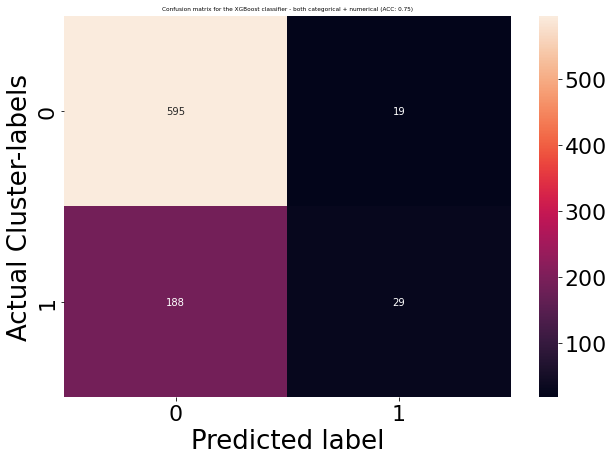

In [30]:
threshold = 0.52
cm = confusion_matrix(y_gold, y_pred_gold > 0.5).astype('float')
accuracy = accuracy_score(y_gold, y_pred_gold  > 0.5).astype('float')


df_cm = pd.DataFrame(cm, index = list(range(len([0,1]))),
                  columns = list(range(len([0,1]))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))#38

Brier score: 0.17780628130318216


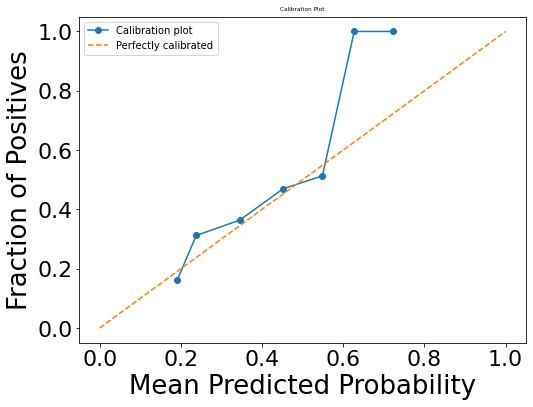

In [31]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

df_pred = pd.DataFrame(y_pred_gold, columns=['pred'] )
df_pred['OA'] = list(y_gold)#.astype(int)

print('Brier score:', brier_score_loss(df_pred['OA'], df_pred['pred']))

# Create a calibration plot
prob_true, prob_pred = calibration_curve(df_pred['OA'], df_pred['pred'], n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.plot(prob_pred, prob_true, marker='o', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.show()

<AxesSubplot:>

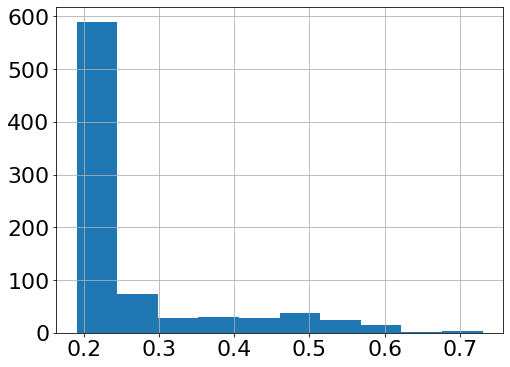

In [32]:
df_pred['pred'].hist()

## # Step 7 Calculate performance per center

In [33]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

df_perf_center = pd.DataFrame(columns=['Center', 'Task', 'ROC-AUC', 'PR-AUC', 'CO_acc', 'CO_tpr', 'CO_spec', 'CO_ppv', 'CO_npv', 'CO_fpr', 'CO_fnr', 'N', 'cases', 'Validation'])

for center in df_replication['Locatie'].unique(): 
    X_gold_test_c = tfidf_vectorizer.transform(df_replication[df_replication['Locatie']==center]['fixedLine'].values)
    y_gold_c = df_replication[df_replication['Locatie']==center][target]
    dgold_c = xgb.DMatrix(X_gold_test_c, label=y_gold_c)

    y_pred_gold_c = bst.predict(dgold_c)
    
    # Test general performance
    fpr_c, tpr_c, _ = roc_curve(y_gold_c, y_pred_gold_c) 
    prec_c, recall_c, _ = precision_recall_curve(y_gold_c, y_pred_gold_c) 

    pr_auc_c = auc(recall_c, prec_c)
    roc_auc_c = auc(fpr_c, tpr_c)
    
    # Test performance with cut-off
    threshold_c = 0.34
    cm_c = confusion_matrix(y_gold_c, np.array(y_pred_gold_c)> threshold_c).astype('float')
    accuracy_c = accuracy_score(y_gold_c, np.array(y_pred_gold_c)> threshold_c).astype('float')
    try: 
        d_scores_c = scoresCM(cm_c)
    except: 
        d_scores_c = {'tpr': np.nan, 'tnr': np.nan, 'ppv': np.nan, 'npv':np.nan, 'fpr': np.nan, 'fnr': np.nan, 'fdr': np.nan, 'acc': np.nan}
        accuracy_c = np.nan

    df_perf_center.loc[len(df_perf_center)] = [center, target, roc_auc_c, pr_auc_c, accuracy_c, d_scores_c['tpr'], d_scores_c['tnr'], d_scores_c['ppv'], d_scores_c['npv'], d_scores_c['fpr'], d_scores_c['fnr'], len(y_gold_c), y_gold_c.sum(), False]


No negative samples in y_true, false positive value should be meaningless
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
No positive samples in y_true, true positive value should be meaningless
invalid value encountered in true_divide
invalid value encountered in double_scalars
invalid value encountered in double_scalars
No negative samples in y_true, false positive value should be meaningless
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


#### Calculate also for validation sets

In [34]:
for center in df_test['Locatie'].unique(): 
    X_feat_test_c = tfidf_vectorizer.transform(df_test[df_test['Locatie']==center]['fixedLine'].values)
    y_lbl_c = df_test[df_test['Locatie']==center][target]
    dtest_c = xgb.DMatrix(X_feat_test_c, label=y_lbl_c)

    y_pred_c = bst.predict(dtest_c)
    
    # Test general performance
    fpr_c, tpr_c, _ = roc_curve(y_lbl_c, y_pred_c) 
    prec_c, recall_c, _ = precision_recall_curve(y_lbl_c, y_pred_c) 

    pr_auc_c = auc(recall_c, prec_c)
    roc_auc_c = auc(fpr_c, tpr_c)
    
    # Test performance with cut-off
    threshold_c = 0.34
    cm_c = confusion_matrix(y_lbl_c, np.array(y_pred_c)> threshold_c).astype('float')
    accuracy_c = accuracy_score(y_lbl_c, np.array(y_pred_c)> threshold_c).astype('float')
    try: 
        d_scores_c = scoresCM(cm_c)
    except: 
        d_scores_c = {'tpr': np.nan, 'tnr': np.nan, 'ppv': np.nan, 'npv':np.nan, 'fpr': np.nan, 'fnr': np.nan, 'fdr': np.nan, 'acc': np.nan}
        accuracy_c = np.nan

    df_perf_center.loc[len(df_perf_center)] = [center, target, roc_auc_c, pr_auc_c, accuracy_c, d_scores_c['tpr'], d_scores_c['tnr'], d_scores_c['ppv'], d_scores_c['npv'], d_scores_c['fpr'], d_scores_c['fnr'], len(y_lbl_c), y_lbl_c.sum(), True]


df_perf_center.to_csv('../proc/performance/Test_OA_performance.csv', index=False)

#### split on demographic

In [35]:
df_perf_subgroup = pd.DataFrame(columns=['Category', 'Groupid', 'Task', 'ROC-AUC', 'PR-AUC', 'CO_acc', 'CO_tpr', 'CO_spec', 'CO_ppv', 'CO_npv', 'CO_fpr', 'CO_fnr', 'N', 'cases'])

# Stratify the age groups using pd.qcut for quantile-based bins
df_test['Age_qt'] = pd.qcut(df_test['Age'], q=4)

for groupby in ['Age_qt', 'Sex']:
    for grp in df_test[groupby].unique(): 
        X_feat_test_c = tfidf_vectorizer.transform(df_test[df_test[groupby]==grp]['fixedLine'].values)
        y_lbl_c = df_test[df_test[groupby]==grp][target]
        dtest_c = xgb.DMatrix(X_feat_test_c, label=y_lbl_c)

        y_pred_c = bst.predict(dtest_c)

        # Test general performance
        fpr_c, tpr_c, _ = roc_curve(y_lbl_c, y_pred_c) 
        prec_c, recall_c, _ = precision_recall_curve(y_lbl_c, y_pred_c) 

        pr_auc_c = auc(recall_c, prec_c)
        roc_auc_c = auc(fpr_c, tpr_c)

        # Test performance with cut-off
        threshold_c = 0.34
        cm_c = confusion_matrix(y_lbl_c, np.array(y_pred_c)> threshold_c).astype('float')
        accuracy_c = accuracy_score(y_lbl_c, np.array(y_pred_c)> threshold_c).astype('float')
        try: 
            d_scores_c = scoresCM(cm_c)
        except: 
            d_scores_c = {'tpr': np.nan, 'tnr': np.nan, 'ppv': np.nan, 'npv':np.nan, 'fpr': np.nan, 'fnr': np.nan, 'fdr': np.nan, 'acc': np.nan}
            accuracy_c = np.nan

        df_perf_subgroup.loc[len(df_perf_subgroup)] = [groupby, grp, target, roc_auc_c, pr_auc_c, accuracy_c, d_scores_c['tpr'], d_scores_c['tnr'], d_scores_c['ppv'], d_scores_c['npv'], d_scores_c['fpr'], d_scores_c['fnr'], len(y_lbl_c), y_lbl_c.sum()]

df_perf_subgroup.to_csv('../proc/performance/Test_OA_Subgroups_performance.csv', index=False)

## #Step 8: Show SHAP values

In [36]:
import shap

N_FEAT = 20
t0 = time.time()
t_explainer = shap.TreeExplainer(bst, feature_names=tfidf_vectorizer.get_feature_names()) # or just X? ,  feature_names=tfidf_feature_names
#df_X_gold_test = tfidf_vectorizer.transform(df_test['fixedLine'])
shap_values = t_explainer( X_feat_test, y)
t1 = time.time()
print('Calculating SHAP: ' + str(t1-t0))

Calculating SHAP: 0.10634779930114746


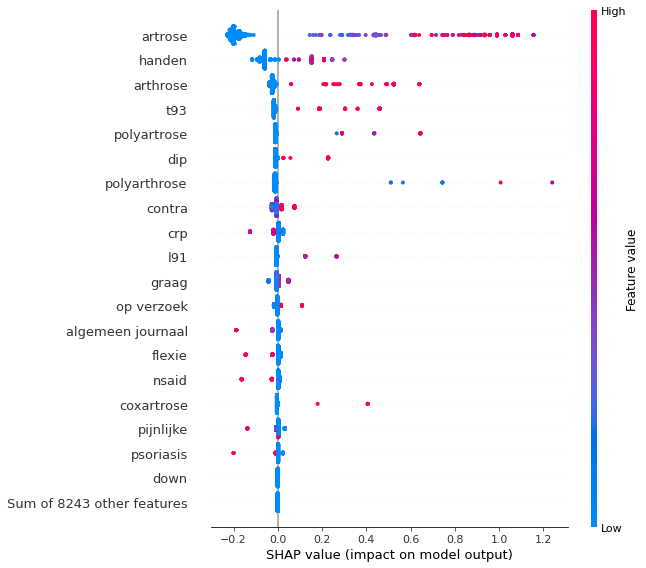

FixedFormatter should only be used together with FixedLocator


<Figure size 576x432 with 0 Axes>

In [37]:
plt.figure(figsize=(2, 2)) # , dpi=80
shap.plots.beeswarm(shap_values, max_display=20) # 20
#shap.summary_plot(pd.DataFrame(data=shap_values, columns = tfidf_feature_names)[feature_names].values, df_shapley[feature_names].values, feature_names=feature_names, show=False, sort=False) # or just X

fig, ax = plt.gcf(), plt.gca()
#ax.set_yticks(tfidf_feature_names)
ax.set_yticklabels(feature_names, fontsize=23) # not sure if we need to reverse this

plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.savefig('../figures/prediction/shap_osteoarthritis_new_top%s.png' % (str(N_FEAT)))
plt.clf()

## [UNUSED] show performance of second referral letters vs first referral letters

In [38]:
# Convert the 'date' column to datetime
df_test['referral_date']= pd.to_datetime(df_test['referral_date'], format='%Y-%m-%d')

# Step 1: Identify patients with more than one row
patient_counts = df_test['Identifier'].value_counts()
patients_with_multiple_rows = patient_counts[patient_counts > 1].index

# Step 2: Filter the dataframe to keep only these patients
df_multiple_rows = df_test[df_test['Identifier'].isin(patients_with_multiple_rows)]

# Step 3: Select the latest row for each patient
df_latest_rows = df_multiple_rows.sort_values('referral_date').drop_duplicates('Identifier', keep='last')

df_first_rows = df_test.sort_values('referral_date').drop_duplicates('Identifier', keep='first')


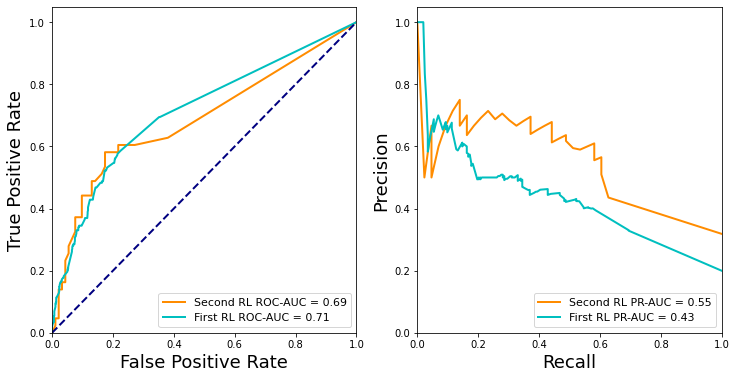

In [39]:
from combat.pycombat import pycombat
from scipy.sparse import csr_matrix

X_sub_2nd = tfidf_vectorizer.transform(df_latest_rows['fixedLine'].values)
y_sub_2nd = df_latest_rows[target]
dsub2nd = xgb.DMatrix(X_sub_2nd, label=y_sub_2nd)

y_pred_sub_2nd = bst.predict(dsub2nd)


X_sub_1st = tfidf_vectorizer.transform(df_first_rows['fixedLine'].values)
y_sub_1st = df_first_rows[target]
dsub1st = xgb.DMatrix(X_sub_1st, label=y_sub_1st)

y_pred_sub_1st = bst.predict(dsub1st)


### import numpy as np

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import re

def binarize(value):
    """
    This function codifies the binary labels 'y' and 'n'
     to 1 and 0.
    """
    return int(value)


fig1, ax1 = plt.subplots(1,2,figsize=(12,6))

clf_name = 'XGBoost (Machine learning)'


# Performance - second referral
fpr_2nd, tpr_2nd, _ = roc_curve(y_sub_2nd, y_pred_sub_2nd) # np.array([binarize(val) for val in y_actual])
prec_2nd, recall_2nd, _ = precision_recall_curve(y_sub_2nd, y_pred_sub_2nd)

pr_auc_2nd = auc(recall_2nd, prec_2nd)
roc_auc_2nd = auc(fpr_2nd, tpr_2nd)

# Performance - first referral
fpr_1st, tpr_1st, _ = roc_curve(y_sub_1st, y_pred_sub_1st) # np.array([binarize(val) for val in y_actual])
prec_1st, recall_1st, _ = precision_recall_curve(y_sub_1st, y_pred_sub_1st)

pr_auc_1st = auc(recall_1st, prec_1st)
roc_auc_1st = auc(fpr_1st, tpr_1st)


lw = 2


# Also plot second referral letters
ax1[0].plot(fpr_2nd, tpr_2nd, color='darkorange',
        lw=lw, label='%s ROC-AUC = %0.2f' % ('Second RL', roc_auc_2nd))
ax1[1].plot(recall_2nd, prec_2nd,  color='darkorange',
        lw=lw, label='%s PR-AUC = %0.2f' % ('Second RL', pr_auc_2nd))

# Also plot first referral letters
ax1[0].plot(fpr_1st, tpr_1st, color='c',
        lw=lw, label='%s ROC-AUC = %0.2f' % ('First RL', roc_auc_1st))
ax1[1].plot(recall_1st, prec_1st,  color='c',
        lw=lw, label='%s PR-AUC = %0.2f' % ('First RL', pr_auc_1st))

## ROC
ax1[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1[0].set_xlim([0.0, 1.0])
ax1[0].set_ylim([0.0, 1.05])
ax1[0].set_xlabel('False Positive Rate', fontsize=18)
ax1[0].set_ylabel('True Positive Rate', fontsize=18)

ax1[0].tick_params(axis='both', which='major', labelsize=10)
ax1[0].tick_params(axis='both', which='minor', labelsize=8)

## PR
ax1[1].set_xlim([0.0, 1.0])
ax1[1].set_ylim([0.0, 1.05])
ax1[1].set_xlabel('Recall', fontsize=18)
ax1[1].set_ylabel('Precision', fontsize=18)

ax1[1].tick_params(axis='both', which='major', labelsize=10)
ax1[1].tick_params(axis='both', which='minor', labelsize=8)

# Plot legend
ax1[1].legend(loc="lower right", fontsize=11)
ax1[0].legend(loc="lower right", fontsize=11)



plt.show()
